In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
from PIL import Image
import random

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

In [3]:
tf.__version__

'1.9.0'

In [4]:
path = "/media/naren/My Passport/studies/programs/DeepLearning/venv/TensorFlow-Tutorials/flowers_resized"    
shape = []
noshape = True
f_t = dict()
one_hot_encoding = dict()
no_types = 5
for i in range(no_types):
    one_hot_encoding[i] = [0]*no_types
    one_hot_encoding[i][i] = 1

data = list()
for flower in os.listdir(path):
    img = Image.open(os.path.join(path,flower)).convert('RGB')
    arr = np.array(img)
    if noshape:
        shape = arr.shape
        print(shape)
        noshape = False
    ft = flower.split("_")[0]
    if not(ft in f_t):
        f_t[ft] = len(f_t)
    flower_type = f_t[ft]
    flower_type_encoded = one_hot_encoding[flower_type]
    datum = [arr.ravel(), flower_type, flower_type_encoded]
    data.append(datum)
print(f_t)

(128, 128, 3)
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [5]:
random.shuffle(data)

In [6]:
num_train = int(len(data)*0.80)
train_data = data[0:num_train-1]
left_over = data[num_train:]
num_val = int(len(left_over)*0.33)
val_data = left_over[0: num_val - 1]
test_data = left_over[num_val:]
num_test = len(test_data)
print("training set: " + str(num_train))
print("validation set: " + str(num_val))
print("test set: " + str(num_test))

training set: 2936
validation set: 242
test set: 492


In [7]:
img_size = shape[0]
img_size_flat = shape[0]*shape[1]*shape[2]
img_shape = shape
img_shape_full = shape
num_classes = len(f_t)
num_channels = shape[2]

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

[[1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0]]


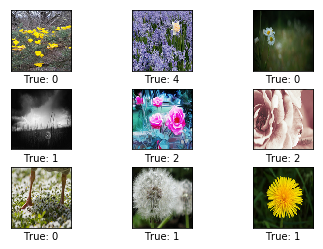

In [9]:
# Get the first images from the test-set.
images = [test_data[i][0] for i in range(9)]
# Get the true classes for those images.
cls_true = [test_data[i][1] for i in range(9)]
print([test_data[i][2] for i in range(9)])

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [11]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 3096 elements,
# but the convolutional layers expect images with shape (32, 32, 3)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu', name = "dense_1"))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax', name = "dense_2"))

In [12]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

In [13]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=np.array([td[0]/255 for td in train_data]),
          y=np.array([td[2] for td in train_data]),
          epochs=1, batch_size=128, shuffle = True)

Epoch 1/1


In [35]:
result = model.evaluate(x=np.array([td[0] for td in test_data]),
                        y=np.array([td[2] for td in test_data]))

492/492 [==============================] - 3s 6ms/step


In [37]:
for name, value in zip(model.metrics_names, result):
    print(name, value)
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

loss 12.383414718193736
acc 0.23170731731546604
acc: 23.17%


[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


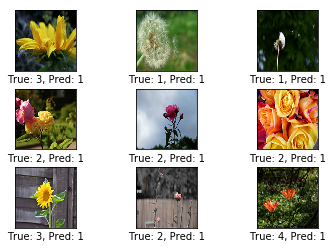

In [38]:
# Get the first images from the test-set.
images = np.array([test_data[i][0]/255 for i in range(9)])
# Get the true classes for those images.
cls_true = np.array([test_data[i][1] for i in range(9)])

y_pred = model.predict(x=images)
print(y_pred)
cls_pred = np.argmax(y_pred, axis=1)

plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)